In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from collections import Iterable
import random
from os import listdir
from os.path import isfile, join

import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


# Calculations for stats and plots are based on: https://github.com/stasmix/popsynth/blob/master/pop-synth-vae.ipynb

# Load the files

In [3]:
dataset = 'Chicago'

In [5]:
synth_dir = '../synth_data/' + dataset

files = ['../data/' + dataset + '/data.csv']
labels = ['original']

for f in listdir(synth_dir):
    if isfile(join(synth_dir, f)):
        files.append(join(synth_dir, f))
        labels.append(f.split('.')[0])

In [7]:
dfs = [pd.read_csv(file) for file in files]

In [8]:
if dataset is 'Chicago':
    continuous_cols = ['distance', 'age', 'departure_time']
elif dataset is 'LPMC':
    continuous_columns = ['start_time_linear', 'age', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'driving_traffic_percent']

In [9]:
dfs[0]

,choice,travel_dow,trip_purpose,distance,hh_vehicles,hh_size,hh_bikes,hh_descr,hh_income,gender,age,license,education_level,work_status,departure_time
0,drive,7,HOME_OTHER,23.42579,2,2,0,2,6,1,66,1.0,6,FTE,9.333333
1,drive,7,OTHER,1.71259,2,2,0,2,6,1,66,1.0,6,FTE,12.083333
2,drive,7,HOME_OTHER,21.77887,2,2,0,2,6,1,66,1.0,6,FTE,15.500000
3,drive,7,SHOPPING,2.02603,2,2,0,2,6,1,66,1.0,6,FTE,17.500000
4,drive,7,SHOPPING,0.87691,2,2,0,2,6,1,66,1.0,6,FTE,18.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87941,drive,2,OTHER,2.42141,1,1,0,1,3,0,59,1.0,4,PTE,13.750000
87942,drive,2,HOME_OTHER,1.16283,1,1,0,1,3,0,59,1.0,4,PTE,14.083333
87943,drive,2,HOME_OTHER,0.54234,1,1,0,1,3,0,59,1.0,4,PTE,14.666667
87944,drive,2,OTHER,1.49183,1,1,0,1,3,0,59,1.0,4,PTE,15.333333


# Transform all values in numerical

In [10]:
if dataset is 'Chicago':
    ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
    floats = ['departure_time', 'distance', 'license']
    strs = ['choice', 'trip_purpose', 'work_status']
elif dataset is 'LPMC':
    ints = []
    floats = []
    strs = []

In [11]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [12]:
dfs = [df.astype(dct) for df in dfs]

In [13]:
for c in strs: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [14]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Compute the stats

In [15]:
# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max(data1, data2, num_bins, cont_cols):
    """
    Create a dictionnary with all variables indicating the number of bins and the min and max value 
    """
    
    min_max = {}
    eps = 1e-10
    
    # Go through all columns in the first dataset (assuming data2 has the same columns)
    for c in data1.columns:
        if c in cont_cols: # Continuous column
            
            # Compute min and max values between both datasets
            min_val = min(np.min(data1[c]), np.min(data2[c])) - eps
            max_val = max(np.max(data1[c]), np.max(data2[c])) + eps
            
            # Fill the dict
            min_max[c] = [min_val, max_val, num_bins]
            
        else: # Categorical column
            # Set of all unique values in both datasets
            unique_vals = set(np.unique(data1[c])).union(set(np.unique(data2[c])))
                                    
            num_bins_cat = min(len(unique_vals), num_bins)
            
            min_max[c] = [min(unique_vals), max(unique_vals), num_bins_cat]
                

    return min_max

In [16]:
def get_frequency_list(original, synthetic, max_num_bins, cat=True):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    if cat:
        unique_vals = set(np.unique(original)).union(set(np.unique(synthetic)))
        
        if len(unique_vals) > max_num_bins:
            cat = False
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = min(np.min(original), np.min(synthetic)) - eps
    max_val = max(np.max(original), np.max(synthetic)) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [17]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [18]:
def plot(freqs_original, freqs_synthetic, title=None, filename=None):
    f = plt.figure(figsize=(10,10))
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

    matplotlib.rc('font', **font)
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
    
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=18)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    plt.xlim((0,8000))
    plt.ylim((0,8000))
    
    if title is not None:
        plt.title(title)
        
    if filename is not None:
        plt.savefig(filename + '.png', bbox_inches='tight')
        plt.savefig(filename + '.pdf', bbox_inches='tight')

# Let's have some fun =)

In [19]:
orig_freqs = []
synth_freqs = []

for i in range(len(dfs)-1):
    synth_freqs.append([])

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50, c not in continuous_cols)
        
        if i == 1:
            orig_freqs.append(a)
        
        synth_freqs[i-1].append(b)

In [20]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [21]:
orig_freqs = list(flatten(orig_freqs))


for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))

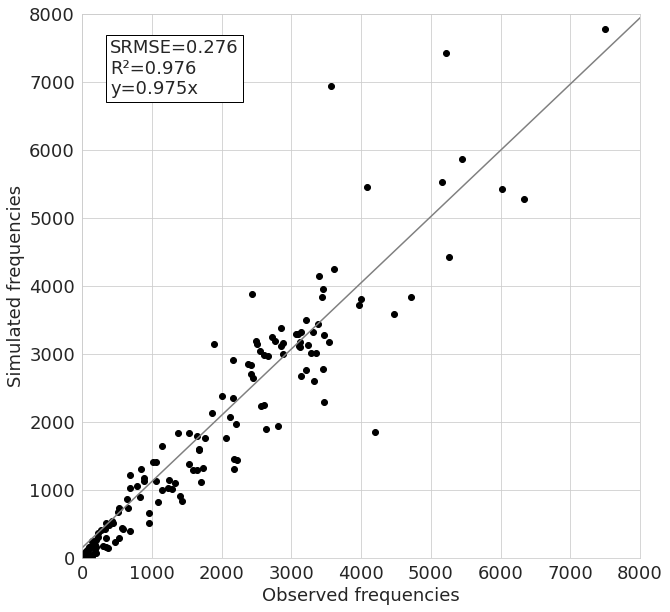

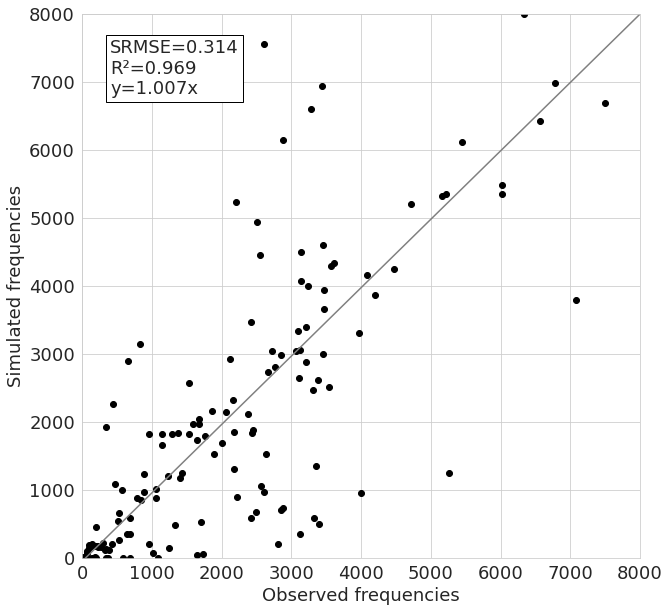

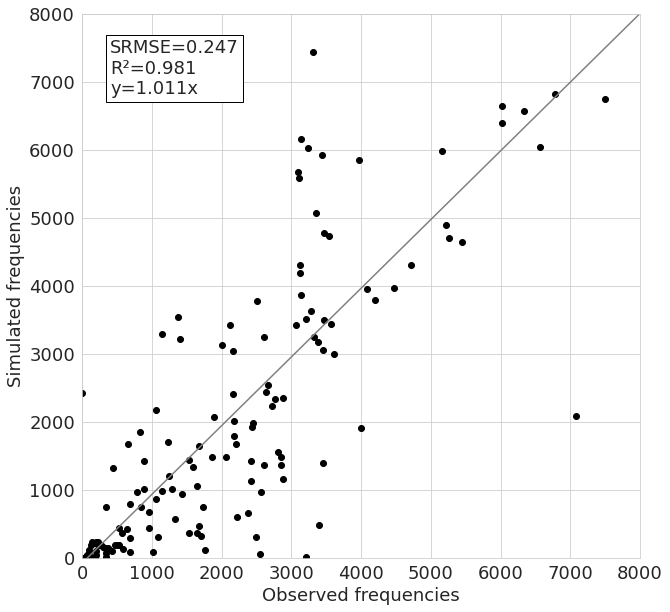

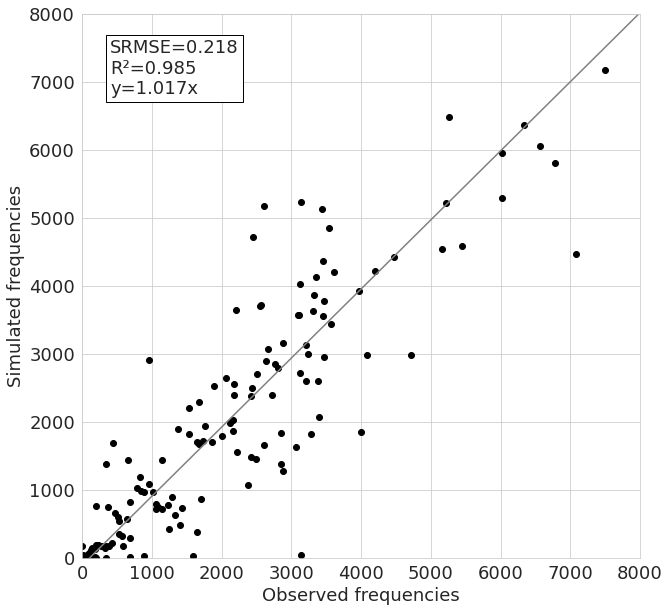

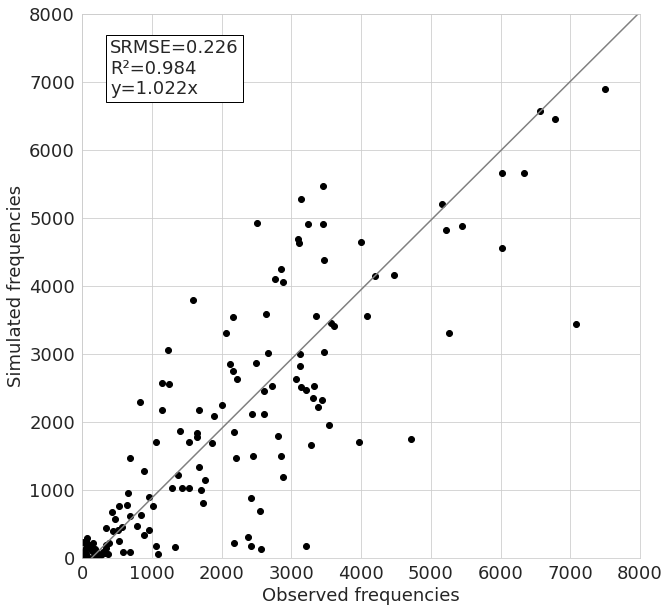

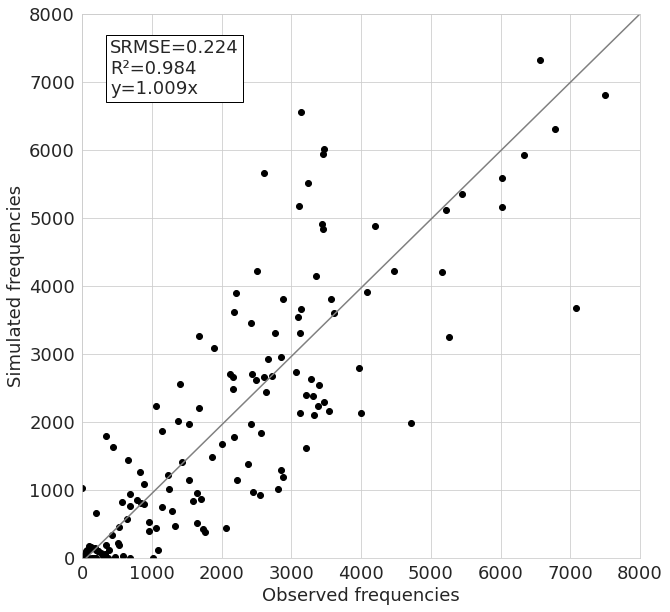

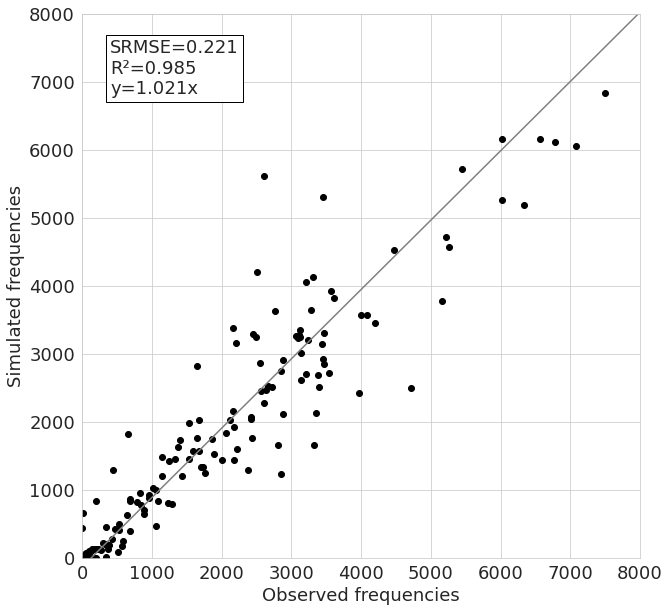

In [24]:
for i in range(len(synth_freqs)):  
    #plot(orig_freqs, synth_freqs[i], labels[0] + ' - ' + labels[i+1])
    plot(orig_freqs, synth_freqs[i], None, '../figures/' + dataset + '/' + labels[i+1])

# Stats by model

In [25]:
stats_vals = []

for i in range(len(dfs)-1):
    stats_vals.append({'mae': [], 'rmse': [], 'r2': [], 'srmse': [], 'corr': []})

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50)
        
        stat = stats(a,b)
        
        for k in stat.keys():
            stats_vals[i-1][k].append(stat[k])
            
n = len(stats_vals)

In [27]:
print("Weighted average of SRMSE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['srmse']), np.std(stats_vals[i]['srmse'])))

Weighted average of SRMSE
CTGAN: 0.189 +- 0.106
DATGAN_POSTLSTM: 0.212 +- 0.364
DATGAN_POSTLSTM_small: 0.175 +- 0.273
DATGAN_PRELSTM: 0.147 +- 0.220
DATGAN_PRELSTM_small: 0.174 +- 0.236
DATGAN_TEST: 0.147 +- 0.202
TGAN: 0.120 +- 0.169


In [28]:
print("Weighted average of RMSE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['rmse']), np.std(stats_vals[i]['rmse'])))

Weighted average of RMSE
CTGAN: 1947.490 +- 1244.668
DATGAN_POSTLSTM: 776.505 +- 511.006
DATGAN_POSTLSTM_small: 732.333 +- 357.749
DATGAN_PRELSTM: 661.794 +- 273.580
DATGAN_PRELSTM_small: 875.985 +- 406.608
DATGAN_TEST: 755.357 +- 288.163
TGAN: 718.373 +- 329.384


In [36]:
print("Weighted average of MAE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['mae']), np.std(stats_vals[i]['mae'])))

Weighted average of MAE
CTGAN: 1447.451 +- 840.525
DATGAN_POSTLSTM: 557.402 +- 270.540
DATGAN_POSTLSTM_small: 553.208 +- 273.183
DATGAN_PRELSTM: 498.942 +- 194.964
DATGAN_PRELSTM_small: 654.304 +- 285.799
DATGAN_TEST: 600.379 +- 224.755
TGAN: 576.173 +- 302.424


In [37]:
print("Weighted average of R^2")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['r2']), np.std(stats_vals[i]['r2'])))

Weighted average of R^2
CTGAN: 0.915 +- 0.088
DATGAN_POSTLSTM: 0.819 +- 0.444
DATGAN_POSTLSTM_small: 0.845 +- 0.355
DATGAN_PRELSTM: 0.906 +- 0.222
DATGAN_PRELSTM_small: 0.857 +- 0.332
DATGAN_TEST: 0.903 +- 0.243
TGAN: 0.964 +- 0.081


In [38]:
print("Weighted average of corr")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['corr']), np.std(stats_vals[i]['corr'])))

Weighted average of corr
CTGAN: 0.962 +- 0.042
DATGAN_POSTLSTM: 0.953 +- 0.113
DATGAN_POSTLSTM_small: 0.958 +- 0.100
DATGAN_PRELSTM: 0.971 +- 0.071
DATGAN_PRELSTM_small: 0.960 +- 0.096
DATGAN_TEST: 0.971 +- 0.069
TGAN: 0.986 +- 0.034


# Continuous vs Categorical

In [39]:
msk = []
for i in range(len(dfs[0].columns)):
    if i in [3, 10, 14]:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)

In [40]:
print("Weighted average of SRMSE for continuous")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['srmse'])[msk]), np.std(np.array(stats_vals[i]['srmse'])[msk])))

Weighted average of SRMSE
CTGAN: 0.221 +- 0.027
DATGAN_POSTLSTM: 0.899 +- 0.265
DATGAN_POSTLSTM_small: 0.721 +- 0.021
DATGAN_PRELSTM: 0.578 +- 0.084
DATGAN_PRELSTM_small: 0.641 +- 0.013
DATGAN_TEST: 0.547 +- 0.037
TGAN: 0.419 +- 0.168


In [41]:
print("Weighted average of SRMSE for discrete")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['srmse'])[~msk]), np.std(np.array(stats_vals[i]['srmse'])[~msk])))

Weighted average of SRMSE
CTGAN: 0.181 +- 0.117
DATGAN_POSTLSTM: 0.040 +- 0.020
DATGAN_POSTLSTM_small: 0.039 +- 0.018
DATGAN_PRELSTM: 0.039 +- 0.019
DATGAN_PRELSTM_small: 0.057 +- 0.042
DATGAN_TEST: 0.047 +- 0.025
TGAN: 0.045 +- 0.022
